# <center>Deep Learning - Neural Networks - Assignment 3</center> 

This assignment is focused on experimenting with RBF Neural Networks and their parameters. Instead of using the MNIST dataset of handwritten digits, for a change, we use the [Chess Evaluations Dataset by Ronak Badhe](https://www.kaggle.com/ronakbadhe/chess-evaluations), found at Kaggle.

It contains chess positions in the Forsyth-Edwards Notation (FEN) as well as their evaluations in centipawns (equal to 100 pawns). 

However, our goal is to decide if a chess position is drawn, winning for white or winning for black. An advange larger than 150 centipawns / 1,5 pawns is considered a winning advantage, given that the optimal moves are played from both sides. Therefore, we change our 'Evaluations' section accordingly.

### <center>Importing Needed Libraries</center>

In [1]:
import numpy as np
import pandas as pd
import re
import chess
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.layers import Layer
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant, Initializer, RandomUniform
from sklearn.cluster import KMeans
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

### <center>Radial Basis Function Neural Network Layer Class</center>

In [3]:
# RBF-Keras: an RBF Layer for Keras Library, by Petra Vidnerová - 2019, parsed from https://github.com/PetraVidnerova/rbf_keras

class RandomInit(Initializer):
  def __init__(self, input):
    self.input = input
    super().__init__()

  def __call__(self, shape, dtype=None):
    assert shape[1:] == self.input.shape[1:]
    idx = np.random.randint(self.input.shape[0], size=shape[0])
    return self.input[idx, :]

class KMeansInit(Initializer):
  def __init__(self, input, max_iter=100):
    self.input = input
    self.max_iter = max_iter
    super().__init__()

  def __call__(self, shape, dtype=None):
    assert shape[1:] == self.input.shape[1:]
    kmeans = KMeans(n_clusters=shape[0], max_iter=self.max_iter)
    kmeans.fit(self.input)
    return kmeans.cluster_centers_

class RbfLayer(Layer):
  def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
    self.output_dim = output_dim
    self.initializer = initializer

    if isinstance(betas, Initializer):
      self.betas_initializer = betas
    else:
      self.betas_initializer = Constant(value=betas)

    if initializer == None:
      self.initializer = RandomUniform(0, 1)

    super().__init__(**kwargs)

  def build(self, input_shape):
    self.centers = self.add_weight(
        name='centers',
        shape=(self.output_dim, input_shape[1]),
        initializer=self.initializer,
        trainable=True
    )

    self.betas = self.add_weight(
        name='betas',
        shape=(self.output_dim,),
        initializer=self.betas_initializer,
        trainable=True
    )

    super().build(input_shape)

  def call(self, input):
    C = tf.expand_dims(self.centers, axis=-1)
    H = tf.transpose(C - tf.transpose(input))
    return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

  def get_config(self):
    config = { 'output_dim': self.output_dim }
    base_config = super().get_config()
    return dict(list(base_config.items()) + list(config.items()))

### <center>Versions of build_model and grid_search compatible with RBF Layers</center>

In [4]:
def build_model_rbf(input_shape, num_classes, rbf_neurons, initializer, betas=1.0):
  model = keras.Sequential(
      [
       layers.Input(shape=input_shape),
       RbfLayer(output_dim=rbf_neurons, initializer=initializer, betas=betas, name="rbf"),
       layers.Dense(num_classes, activation="softmax", name="output")
      ]
  )
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [5]:
def grid_search_rbf(x_train, y_train, num_classes, param_grid, rbf_neurons=None):
  if rbf_neurons:
    base_model = KerasClassifier(build_fn=build_model_rbf, input_shape=x_train[0].shape, num_classes=num_classes, rbf_neurons=rbf_neurons)
  else:
    base_model = KerasClassifier(build_fn=build_model_rbf, input_shape=x_train[0].shape, num_classes=num_classes)
  grid = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=3, refit=False, verbose=2)
  grid.fit(x_train, y_train)
  print("Best params:", grid.best_params_)
  print("Score:", grid.best_score_)
  return grid

### <center>Function to plot the history of a specific model</center>

In [6]:
def plot_history(model, history, epochs, title):
    train_loss = history.history['loss']
    val_loss   = history.history['val_loss']
    train_acc  = history.history['accuracy']
    val_acc    = history.history['val_accuracy']
    x = list(range(1, epochs+1))
    plt.figure()
    plt.xlabel('Epochs')
    plt.title(title)
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, val_loss, label = 'validation_loss')
    plt.plot(x, train_acc, label = 'train_accuracy')
    plt.plot(x, val_acc, label = 'validation_accuracy')
    plt.legend()
    plt.savefig(title)
    plt.show()

### <center>Function to transform FEN notation strings to vectors</center>

In [2]:
# Function to transform a chess position in Forsyth-Edwards Notation (FEN) to a bit vector

# Piece Placement:
#   Lowercase latters stand for black pieces, Uppercase ones for white pieces
#   Numbers represent consequtive spaces and / represents a new row 
# Active color:
#   Indicates whose turn it is to play, either 'w' for white or 'b' for black
# Castling Rights:
#   Indicates the castling moves that are still legal 
#   K or k for kingside and Q or q for queenside, '-' if there are no legal castling moves for any colour
# En passant:
#   If the last move was a pawn moving up two squares, this is the space behind the square for the en passant move to be played
# Halfmove count:
#   Indicates the number of moves without a pawn move or piece capture, 50 consecutive such moves result in a draw
# Fullmove count:
#   Indicates the number of full turns starting at 1, incremented after black pieces make a move

# Example FEN string of the starting position:
# rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


def fen_to_vector(fen_string):
    parts = re.split(" ", fen_string)
    piece_placement = re.split("/", parts[0])
    active_color = parts[1]
    castling_rights = parts[2]
    en_passant = parts[3]
    halfmove_count = int(parts[4])
    fullmove_count = int(parts[5])

    bit_vector = np.zeros((13, 8, 8), dtype=np.uint8)
    
    # Assignment of a piece to a certain 'layer'
    piece_to_layer = {
        'R': 1,
        'N': 2,
        'B': 3,
        'Q': 4,
        'K': 5,
        'P': 6,
        'p': 7,
        'k': 8,
        'q': 9,
        'b': 10,
        'n': 11,
        'r': 12
    }
    
    # Castling rights
    castling_rights = {
        'K': (7,7),
        'Q': (7,0),
        'k': (0,7),
        'q': (0,0),
    }

    for r, row in enumerate(piece_placement):
        c = 0
        for piece in row:
            if piece in piece_to_layer:
                bit_vector[piece_to_layer[piece], r, c] = 1
                c += 1
            else:
                c += int(piece)
    
    if en_passant != '-':
        bit_vector[0, ord(en_passant[0]) - ord('a'), int(en_passant[1]) - 1] = 1
    
    if castling_rights != '-':
        for char in castling_rights:
            bit_vector[0, castling_rights[char][0], castling_rights[char][1]] = 1
    
    if active_color == 'w':
        bit_vector[0, 7, 4] = 1
    else:
        bit_vector[0, 0, 4] = 1

    if halfmove_count > 0:
        c = 7
        while halfmove_count > 0:
            bit_vector[0, 3, c] = halfmove_count % 2
            halfmove_clock = halfmove_count // 2
            c -= 1
            if c < 0:
                break

    if fullmove_count > 0:
        c = 7
        while fullmove_count > 0:
            bit_vector[0, 4, c] = fullmove_count % 2
            fullmove_count = fullmove_count // 2
            c -= 1
            if c < 0:
                break

    return bit_vector

### <center>Showcase of chess positions</center>

We display the starting chess position as well as two other random ones along with their generated vectors for comparison

[[[1 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 0 0 0 1 0 0 1]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 1]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 1 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 1 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0

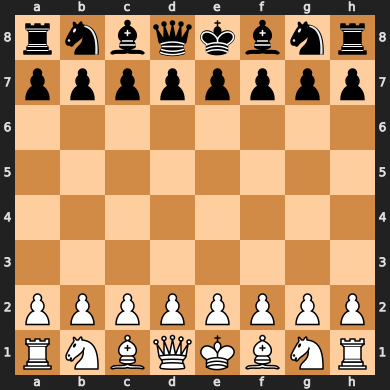

In [3]:
# The 13 * 8 * 8 vector represents:

# Board 0  : Castling rights / Possible 'en-passant' moves / Colour to move
# Board 1  : Position(s) of White Rook(s)
# Board 2  : Position(s) of White Knight(s)
# Board 3  : Position(s) of White Bishop(s)
# Board 4  : Position(s) of White Queen(s)
# Board 5  : Position    of White King
# Board 6  : Position(s) of White Pawn(s)
# Board 7  : Position(s) of Black Pawn(s)
# Board 8  : Position    of Black King
# Board 9  : Position(s) of Black Queen(s)
# Board 10 : Position(s) of Black Bishop(s)
# Board 11 : Position(s) of Black Knight(s)
# Board 12 : Position(s) of Black Rook(s)

fen_string = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
board = fen_to_vector(fen_string)
print(board)
chess.Board(fen_string)

[[[1 0 0 0 1 0 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 1 0 1 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 1]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 1]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0

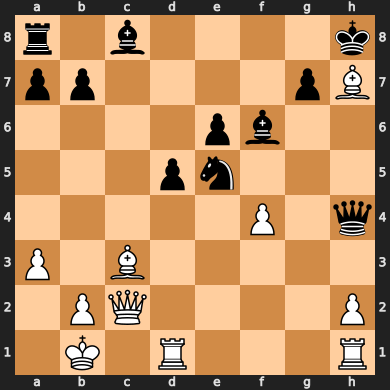

In [4]:
fen_string = "r1b4k/pp4pB/4pb2/3pn3/5P1q/P1B5/1PQ4P/1K1R3R b - - 0 21"
board = fen_to_vector(fen_string)
print(board)
chess.Board(fen_string)

[[[1 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 1 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 0 0 0 1 0 0 1]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 0 0 0 0 1 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0

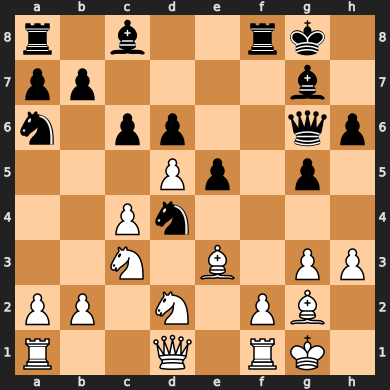

In [5]:
fen_string = "r1b2rk1/pp4b1/n1pp2qp/3Pp1p1/2Pn4/2N1B1PP/PP1N1PB1/R2Q1RK1 w - - 2 18"
board = fen_to_vector(fen_string)
print(board)
chess.Board(fen_string)

### <center>Importing our Dataset</center>

The dataset is extremely large, with over 12 million chess positions with their evaulations. For this assignment, we will extract a total of 100000 samples, later split into training and testing sets.

In [6]:
dataFrame = pd.read_csv('chessData.csv', nrows = 100000, index_col=0)
dataFrame.reset_index(inplace=True)

train, test = train_test_split(dataFrame, test_size = 0.4, random_state=69)

x_training = train['FEN'].reset_index(drop=True)
x_training.to_csv(path_or_buf='x_training.csv')
x_testing = test['FEN'].reset_index(drop=True)
x_testing.to_csv(path_or_buf='x_testing.csv')

y_training = train['Evaluation'].reset_index(drop=True)
y_testing = test['Evaluation'].reset_index(drop=True)

### <center>Switching from Evaulations to our new Labels, 'Drawn' - 'Winning for White' - 'Winning for Black' </center>

As mentioned previously, an advantage larger than 150 centipawns is considered winning. When black is in advantage, the value is negative. 

It is quite likely that in the 'Evaluations' section, we will come across of a string in the format '#+N' or '#-N'. This means that in the current given position, there is a forced Checkmate pattern for White/Black (+/-) in N moves, meaning a secured win. We have to deal with these cases also when changing labels.

We use 1 for white winning, 0 for a draw and -1 for black winning.

In [7]:
for i,x in enumerate(y_training):
    if ('#+' in x):
      y_training[i] = 1
    elif ('#-' in x):
      y_training[i] = -1
    elif(int(x) >= 150):
      y_training[i] = 1
    elif(int(x) <= -150):
      y_training[i] = -1
    elif(int(x) > -150 and int(x) < 150):
      y_training[i] = 0

y_training.to_csv(path_or_buf='y_training.csv')

for i,x in enumerate(y_testing):
    if ('#+' in x):
      y_testing[i] = 1
    elif ('#-' in x):
      y_testing[i] = -1
    elif(int(x) >= 150 or '#+' in x):
      y_testing[i] = 1
    elif(int(x) <= -150 or '#-' in x):
      y_testing[i] = -1
    elif(int(x) > -150 and int(x) < 150):
      y_testing[i] = 0

y_testing.to_csv(path_or_buf='y_testing.csv')

### <center>Manipulating our Dataset and applying PCA</center>

In [8]:
x_train_bit_vector = np.array([fen_to_vector(x) for x in x_training])
x_test_bit_vector = np.array([fen_to_vector(x) for x in x_testing])

x_train_reshaped = x_train_bit_vector.reshape(60000, 13*8*8)
x_test_reshaped = x_test_bit_vector.reshape(40000, 13*8*8)

pca = PCA(0.9, random_state=69)
pca.fit(x_train_reshaped)

x_train_pca = pca.transform(x_train_reshaped)
x_test_pca = pca.transform(x_test_reshaped)

y_train = to_categorical(y_training, 3)
y_test = to_categorical(y_testing, 3)

### <center>Nearest Neighbor(s) and Nearest Centroid</center>

In [13]:
nn = neighbors.KNeighborsClassifier(n_neighbors = 1, algorithm = 'auto').fit(x_train_reshaped, y_train)
print("Nearest Neighbor with no PCA accuracy:", nn.score(x_test_reshaped, y_test))

nn = neighbors.KNeighborsClassifier(n_neighbors = 1, algorithm = 'auto').fit(x_train_pca, y_train)
print("Nearest Neighbor with PCA accuracy:", nn.score(x_test_pca, y_test))

Nearest Neighbor with no PCA accuracy: 0.906625
Nearest Neighbor with PCA accuracy: 0.896675


In [14]:
three_nn = neighbors.KNeighborsClassifier(n_neighbors = 3, algorithm = 'auto').fit(x_train_reshaped, y_train)
print("Three Nearest Neighbors with no PCA accuracy:", three_nn.score(x_test_reshaped, y_test))

three_nn = neighbors.KNeighborsClassifier(n_neighbors = 1, algorithm = 'auto').fit(x_train_pca, y_train)
print("Three Nearest Neighbors with PCA accuracy:", three_nn.score(x_test_pca, y_test))

Three Nearest Neighbors with no PCA accuracy: 0.90965
Three Nearest Neighbors with PCA accuracy: 0.896675


In [15]:
nc = neighbors.NearestCentroid().fit(x_train_reshaped, y_training.astype('int'))
print("Nearest Centroid with no PCA accuracy:", nc.score(x_test_reshaped, y_testing.astype('int')))

nc = neighbors.NearestCentroid().fit(x_train_pca, y_training.astype('int'))
print("Nearest Centroid with PCA accuracy:", nc.score(x_test_pca, y_testing.astype('int')))

Nearest Centroid with no PCA accuracy: 0.580925
Nearest Centroid with PCA accuracy: 0.577875


### <center>Radial Basis Fuction Neural Networks - Various Models</center>

In [14]:
random_initializer = RandomInit(x_train_reshaped)
kMeans_Initializer = KMeansInit(x_train_reshaped)
initializers = [random_initializer, kMeans_Initializer]

#### <center>Grid Search on batch_size and epochs number</center>

In [17]:
num_classes = 3
rbf_neurons = 3
batch_size = [16, 32, 64]
epochs = [10, 20, 30]

grid_parameters = dict(batch_size=batch_size, epochs=epochs, initializer=initializers)
grid = grid_search_rbf(x_train_reshaped, y_train, num_classes, grid_parameters, rbf_neurons)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.8568 - accuracy: 0.6975
Epoch 2/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8144 - accuracy: 0.6975
Epoch 3/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8145 - accuracy: 0.6975
Epoch 4/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8145 - accuracy: 0.6975
Epoch 5/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8145 - accuracy: 0.6975
Epoch 6/10
2500/2500 [==============================] - 9s 3ms/step - loss: 0.8144 - accuracy: 0.6975
Epoch 7/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.8145 - accuracy: 0.6975
Epoch 8/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.8144 - accuracy: 0.6975
Epoch 9/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.8145 - accuracy: 0.6975
Epoch 10/10
1250/

In [18]:
df = pd.DataFrame(grid.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_initializer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,102.686393,28.627064,2.722813,0.014369,16,10,<__main__.RandomInit object at 0x7f0ad6939210>,"{'batch_size': 16, 'epochs': 10, 'initializer'...",0.69150,0.69410,0.70095,0.695517,0.003986,2
1,100.929409,8.529499,2.621323,0.104304,16,10,<__main__.KMeansInit object at 0x7f0ad6939c90>,"{'batch_size': 16, 'epochs': 10, 'initializer'...",0.68615,0.69720,0.70040,0.694583,0.006105,12
2,137.330254,7.190659,2.595731,0.097528,16,20,<__main__.RandomInit object at 0x7f0ad6939210>,"{'batch_size': 16, 'epochs': 20, 'initializer'...",0.68735,0.69410,0.69710,0.692850,0.004077,15
3,162.905951,2.807680,2.636786,0.100281,16,20,<__main__.KMeansInit object at 0x7f0ad6939c90>,"{'batch_size': 16, 'epochs': 20, 'initializer'...",0.69200,0.69390,0.70015,0.695350,0.003482,8
4,242.532190,28.374995,2.699879,0.003787,16,30,<__main__.RandomInit object at 0x7f0ad6939210>,"{'batch_size': 16, 'epochs': 30, 'initializer'...",0.69145,0.69590,0.70095,0.696100,0.003881,1
5,258.330573,22.536491,4.395471,1.228881,16,30,<__main__.KMeansInit object at 0x7f0ad6939c90>,"{'batch_size': 16, 'epochs': 30, 'initializer'...",0.68820,0.69130,0.68515,0.688217,0.002511,18
6,82.428165,0.006979,2.446371,0.384361,32,10,<__main__.RandomInit object at 0x7f0ad6939210>,"{'batch_size': 32, 'epochs': 10, 'initializer'...",0.69150,0.69410,0.70095,0.695517,0.003986,2
7,103.058751,16.238218,2.402905,0.428164,32,10,<__main__.KMeansInit object at 0x7f0ad6939c90>,"{'batch_size': 32, 'epochs': 10, 'initializer'...",0.68930,0.68665,0.70095,0.692300,0.006211,16
8,128.077514,20.701745,2.150300,0.396640,32,20,<__main__.RandomInit object at 0x7f0ad6939210>,"{'batch_size': 32, 'epochs': 20, 'initializer'...",0.69150,0.69410,0.70095,0.695517,0.003986,2
9,158.799217,20.814207,2.419529,0.423048,32,20,<__main__.KMeansInit object at 0x7f0ad6939c90>,"{'batch_size': 32, 'epochs': 20, 'initializer'...",0.69470,0.68875,0.70155,0.695000,0.005230,9


Epoch 1/30
3000/3000 [==============================] - 14s 4ms/step - loss: 0.8531 - accuracy: 0.6943 - val_loss: 0.8099 - val_accuracy: 0.7003
Epoch 2/30
3000/3000 [==============================] - 12s 4ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8098 - val_accuracy: 0.7003
Epoch 3/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8098 - val_accuracy: 0.7003
Epoch 4/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8098 - val_accuracy: 0.7003
Epoch 5/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8100 - val_accuracy: 0.7003
Epoch 6/30
3000/3000 [==============================] - 13s 4ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8098 - val_accuracy: 0.7003
Epoch 7/30
3000/3000 [==============================] - 12s 4ms/step - loss: 0.8154 - accuracy: 0.6943 - val_loss: 0.7752 - val_ac

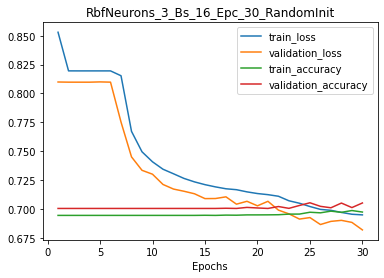

In [34]:
model_1 = build_model_rbf(input_shape = x_train_reshaped[0].shape, num_classes = 3, rbf_neurons = 3, initializer = random_initializer, betas=1.0)
history_1 = model_1.fit(x_train_reshaped, y_train, epochs=30, batch_size=16, validation_split = 0.2, verbose = 1)
plot_history(model_1, history_1, 30, 'RbfNeurons_3_Bs_16_Epc_30_RandomInit')

Epoch 1/10
1500/1500 [==============================] - 9s 5ms/step - loss: 0.8814 - accuracy: 0.6943 - val_loss: 0.8125 - val_accuracy: 0.7003
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.8200 - accuracy: 0.6943 - val_loss: 0.8100 - val_accuracy: 0.7003
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8099 - val_accuracy: 0.7003
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8100 - val_accuracy: 0.7003
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8098 - val_accuracy: 0.7003
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8098 - val_accuracy: 0.7003
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.8195 - accuracy: 0.6943 - val_loss: 0.8098 - val_accuracy:

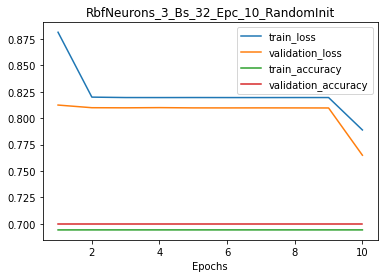

In [35]:
model_2 = build_model_rbf(input_shape = x_train_reshaped[0].shape, num_classes = 3, rbf_neurons = 3, initializer = random_initializer, betas=1.0)
history_2 = model_2.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_split = 0.2, verbose = 1)
plot_history(model_2, history_2, 10, 'RbfNeurons_3_Bs_32_Epc_10_RandomInit')

Epoch 1/10
750/750 [==============================] - 6s 7ms/step - loss: 0.9333 - accuracy: 0.6943 - val_loss: 0.8393 - val_accuracy: 0.7003
Epoch 2/10
750/750 [==============================] - 6s 7ms/step - loss: 0.8285 - accuracy: 0.6943 - val_loss: 0.8121 - val_accuracy: 0.7003
Epoch 3/10
750/750 [==============================] - 6s 8ms/step - loss: 0.8200 - accuracy: 0.6943 - val_loss: 0.8099 - val_accuracy: 0.7003
Epoch 4/10
750/750 [==============================] - 6s 7ms/step - loss: 0.8196 - accuracy: 0.6943 - val_loss: 0.8098 - val_accuracy: 0.7003
Epoch 5/10
750/750 [==============================] - 6s 8ms/step - loss: 0.8116 - accuracy: 0.6943 - val_loss: 0.7776 - val_accuracy: 0.7003
Epoch 6/10
750/750 [==============================] - 6s 8ms/step - loss: 0.7759 - accuracy: 0.6943 - val_loss: 0.7567 - val_accuracy: 0.7003
Epoch 7/10
750/750 [==============================] - 6s 8ms/step - loss: 0.7613 - accuracy: 0.6943 - val_loss: 0.7463 - val_accuracy: 0.7003
Epoch 

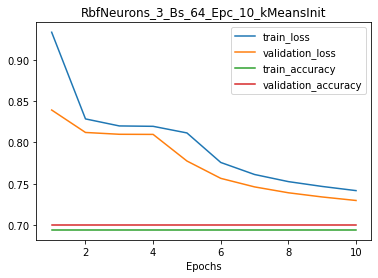

In [36]:
model_3 = build_model_rbf(input_shape = x_train_reshaped[0].shape, num_classes = 3, rbf_neurons = 3, initializer = random_initializer, betas=1.0)
history_3 = model_3.fit(x_train_reshaped, y_train, epochs=10, batch_size=64, validation_split = 0.2, verbose = 1)
plot_history(model_3, history_3, 10, 'RbfNeurons_3_Bs_64_Epc_10_kMeansInit')

#### <center>Grid Search on RBF Neurons number and beta values</center>

In [26]:
rbf_neurons = [num_classes, 2*num_classes, 5*num_classes]
betas = [0.5, 2.0]

grid2_parameters = dict(batch_size=[16], epochs=[30], rbf_neurons=rbf_neurons, betas=betas, initializer=initializers)
grid2 = grid_search_rbf(x_train_reshaped, y_train, num_classes, grid2_parameters)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Epoch 1/30
2500/2500 [==============================] - 8s 3ms/step - loss: 0.8129 - accuracy: 0.6975
Epoch 2/30
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7495 - accuracy: 0.6975
Epoch 3/30
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7354 - accuracy: 0.6975
Epoch 4/30
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7272 - accuracy: 0.6975
Epoch 5/30
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7221 - accuracy: 0.6975
Epoch 6/30
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7180 - accuracy: 0.6975
Epoch 7/30
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7148 - accuracy: 0.6975
Epoch 8/30
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7130 - accuracy: 0.6976
Epoch 9/30
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7107 - accuracy: 0.6977
Epoch 10/30
2500/2500

In [27]:
df2 = pd.DataFrame(grid2.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_betas,param_epochs,param_initializer,param_rbf_neurons,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,238.430055,20.893143,3.590535,1.207349,16,0.5,30,<__main__.RandomInit object at 0x7f0ad6939210>,3,"{'batch_size': 16, 'betas': 0.5, 'epochs': 30,...",0.69265,0.69490,0.70130,0.696283,0.003664,5
1,342.742951,28.606195,4.207783,0.803971,16,0.5,30,<__main__.RandomInit object at 0x7f0ad6939210>,6,"{'batch_size': 16, 'betas': 0.5, 'epochs': 30,...",0.69150,0.69670,0.70305,0.697083,0.004723,4
2,441.121969,1.911776,4.997931,0.215820,16,0.5,30,<__main__.RandomInit object at 0x7f0ad6939210>,15,"{'batch_size': 16, 'betas': 0.5, 'epochs': 30,...",0.71335,0.70470,0.72250,0.713517,0.007268,1
3,314.320303,26.823515,5.288537,0.006052,16,0.5,30,<__main__.KMeansInit object at 0x7f0ad6939c90>,3,"{'batch_size': 16, 'betas': 0.5, 'epochs': 30,...",0.69275,0.69375,0.70220,0.696233,0.004239,6
4,387.440458,7.074050,4.843970,0.645313,16,0.5,30,<__main__.KMeansInit object at 0x7f0ad6939c90>,6,"{'batch_size': 16, 'betas': 0.5, 'epochs': 30,...",0.69195,0.70470,0.70390,0.700183,0.005831,3
5,596.312994,13.624943,5.257950,0.047684,16,0.5,30,<__main__.KMeansInit object at 0x7f0ad6939c90>,15,"{'batch_size': 16, 'betas': 0.5, 'epochs': 30,...",0.71550,0.70970,0.70785,0.711017,0.003259,2
6,303.776861,26.465141,4.693088,0.835041,16,2,30,<__main__.RandomInit object at 0x7f0ad6939210>,3,"{'batch_size': 16, 'betas': 2.0, 'epochs': 30,...",0.69150,0.69410,0.70095,0.695517,0.003986,7
7,371.443056,15.615594,4.437424,0.605477,16,2,30,<__main__.RandomInit object at 0x7f0ad6939210>,6,"{'batch_size': 16, 'betas': 2.0, 'epochs': 30,...",0.69150,0.69410,0.70095,0.695517,0.003986,7
8,501.195282,2.695916,5.348180,0.068907,16,2,30,<__main__.RandomInit object at 0x7f0ad6939210>,15,"{'batch_size': 16, 'betas': 2.0, 'epochs': 30,...",0.69150,0.69410,0.70095,0.695517,0.003986,7
9,342.217414,21.945852,4.718691,0.802654,16,2,30,<__main__.KMeansInit object at 0x7f0ad6939c90>,3,"{'batch_size': 16, 'betas': 2.0, 'epochs': 30,...",0.69150,0.69410,0.70095,0.695517,0.003986,7


Epoch 1/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.8306 - accuracy: 0.6941 - val_loss: 0.7375 - val_accuracy: 0.7003
Epoch 2/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.7347 - accuracy: 0.6916 - val_loss: 0.7196 - val_accuracy: 0.7001
Epoch 3/30
3000/3000 [==============================] - 13s 4ms/step - loss: 0.7233 - accuracy: 0.6908 - val_loss: 0.7188 - val_accuracy: 0.6956
Epoch 4/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.7147 - accuracy: 0.6911 - val_loss: 0.6970 - val_accuracy: 0.7009
Epoch 5/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.7059 - accuracy: 0.6924 - val_loss: 0.6969 - val_accuracy: 0.6971
Epoch 6/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.7017 - accuracy: 0.6916 - val_loss: 0.6945 - val_accuracy: 0.7004
Epoch 7/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.6972 - accuracy: 0.6941 - val_loss: 0.6834 - val_ac

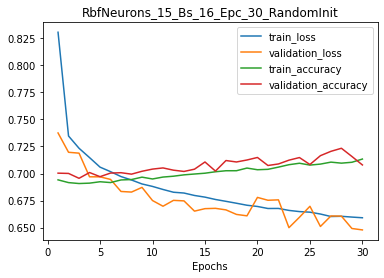

In [20]:
model_4 = build_model_rbf(input_shape = x_train_reshaped[0].shape, num_classes = 3, rbf_neurons = 15, initializer = random_initializer, betas=0.5)
history_4 = model_4.fit(x_train_reshaped, y_train, epochs=30, batch_size=16, validation_split = 0.2, verbose = 1)
plot_history(model_4, history_4, 30, 'RbfNeurons_15_Bs_16_Epc_30_RandomInit')

Epoch 1/30
3000/3000 [==============================] - 23s 8ms/step - loss: 0.7986 - accuracy: 0.6941 - val_loss: 0.7277 - val_accuracy: 0.6986
Epoch 2/30
3000/3000 [==============================] - 22s 7ms/step - loss: 0.7212 - accuracy: 0.6923 - val_loss: 0.7024 - val_accuracy: 0.6995
Epoch 3/30
3000/3000 [==============================] - 22s 7ms/step - loss: 0.7106 - accuracy: 0.6929 - val_loss: 0.6992 - val_accuracy: 0.6992
Epoch 4/30
3000/3000 [==============================] - 22s 7ms/step - loss: 0.7038 - accuracy: 0.6930 - val_loss: 0.6884 - val_accuracy: 0.7003
Epoch 5/30
3000/3000 [==============================] - 22s 7ms/step - loss: 0.6974 - accuracy: 0.6933 - val_loss: 0.6854 - val_accuracy: 0.7016
Epoch 6/30
3000/3000 [==============================] - 22s 7ms/step - loss: 0.6929 - accuracy: 0.6951 - val_loss: 0.6808 - val_accuracy: 0.7007
Epoch 7/30
3000/3000 [==============================] - 22s 7ms/step - loss: 0.6891 - accuracy: 0.6961 - val_loss: 0.6730 - val_ac

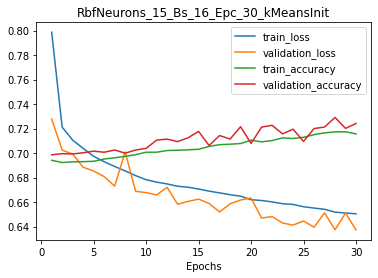

In [38]:
model_5 = build_model_rbf(input_shape = x_train_reshaped[0].shape, num_classes = 3, rbf_neurons = 15, initializer = random_initializer, betas=0.5)
history_5 = model_5.fit(x_train_reshaped, y_train, epochs=30, batch_size=16, validation_split = 0.2, verbose = 1)
plot_history(model_5, history_5, 30, 'RbfNeurons_15_Bs_16_Epc_30_kMeansInit')

### <center>Showcase of Right-Wrong Predictions</center>

Here are some 'hand-picked' samples to showcase right and wrong predictions, covering all possible cases.

Predicted Win for White - Actual Win for White


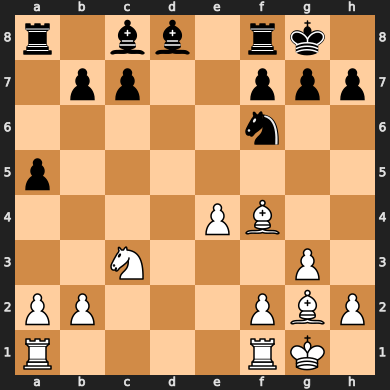

In [9]:
print('Predicted Win for White - Actual Win for White')
chess.Board(x_testing[21])

Predicted Win for White - Actual Drawn Position


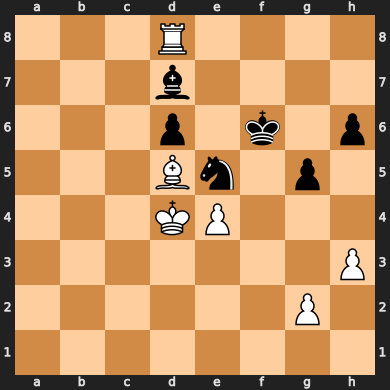

In [10]:
print('Predicted Win for White - Actual Drawn Position')
chess.Board(x_testing[1])

Predicted Win for White - Actual Win for Black


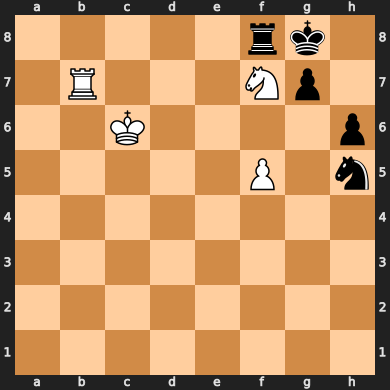

In [11]:
print('Predicted Win for White - Actual Win for Black')
chess.Board(x_testing[13])

Predicted Draw - Actual Win for White


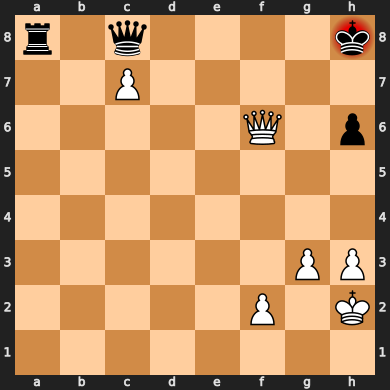

In [12]:
print('Predicted Draw - Actual Win for White')
chess.Board(x_testing[341])

Predicted Draw - Actual Drawn Position


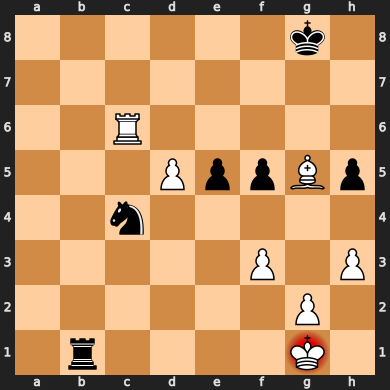

In [13]:
print('Predicted Draw - Actual Drawn Position')
chess.Board(x_testing[33])

Predicted Draw - Actual Win for Black


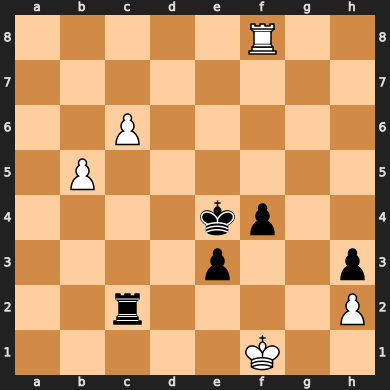

In [14]:
print('Predicted Draw - Actual Win for Black')
chess.Board(x_testing[213])

Predicted Win for Black - Actual Win for White


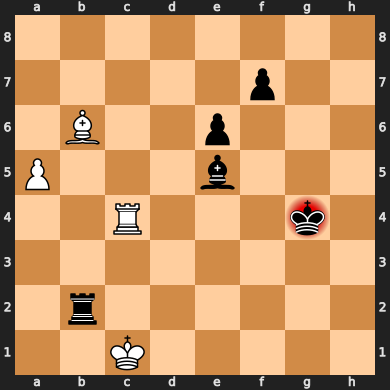

In [15]:
print('Predicted Win for Black - Actual Win for White')
chess.Board(x_testing[256])

Predicted Win for Black - Actual Drawn Position


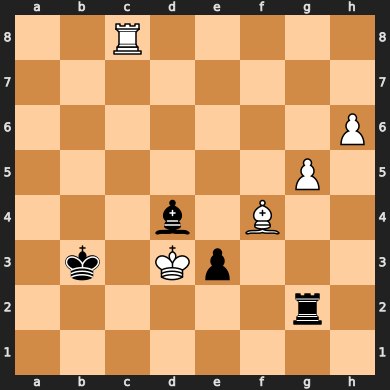

In [16]:
print('Predicted Win for Black - Actual Drawn Position')
chess.Board(x_testing[61])

Predicted Win for Black - Actual Win for Black


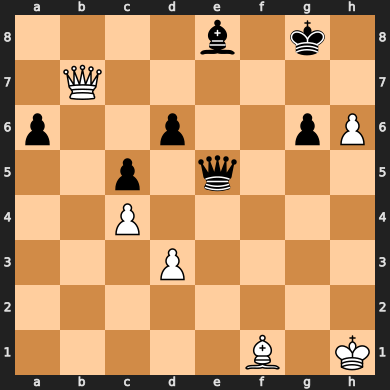

In [17]:
print('Predicted Win for Black - Actual Win for Black')
chess.Board(x_testing[368])